In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
# Cargar y preparar datos
data = pd.read_csv('teleCust1000t.csv')
X = data.drop('custcat', axis=1)
y = data['custcat']

# Feature Engineering específico
def create_features(X):
    X_new = X.copy()

    # Ratios e interacciones importantes
    X_new['income_per_tenure'] = X_new['income'] / (X_new['tenure'] + 1)
    X_new['income_per_age'] = X_new['income'] / (X_new['age'] + 1)
    X_new['services_per_tenure'] = (X_new['address'] + X_new['employ']) / (X_new['tenure'] + 1)

    # Features cuadráticos para variables clave
    X_new['income_squared'] = X_new['income'] ** 2
    X_new['tenure_squared'] = X_new['tenure'] ** 2

    # Interacciones específicas
    X_new['income_education'] = X_new['income'] * X_new['ed']
    X_new['age_income'] = X_new['age'] * X_new['income']

    # Features categóricos transformados
    X_new['high_value_customer'] = (X_new['income'] > X_new['income'].median()).astype(int)
    X_new['long_tenure'] = (X_new['tenure'] > X_new['tenure'].median()).astype(int)

    return X_new

In [ ]:
df= [income_per_tenure]

In [32]:
# Preprocesamiento
X = create_features(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


In [33]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Balanceo con SMOTEENN (combinación de over y undersampling)
smote_enn = SMOTEENN(sampling_strategy={2: max(dict(zip(*np.unique(y_train, return_counts=True))).values())},
                     random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)


In [35]:
# Configuración del Random Forest con hiperparámetros optimizados para clase 3
rf_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'class_weight': {0: 1, 1: 1, 2: 1.5, 3: 1,4:1},  # Mayor peso a la clase 2
    'bootstrap': True,
    'random_state': 42
}

# Entrenamiento del modelo
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(class_weight={0: 1, 1: 1, 2: 1.5, 3: 1, 4: 1},
                       max_depth=15, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=200, random_state=42)


Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.50      0.34      0.40        53
           2       0.27      0.77      0.40        44
           3       0.57      0.21      0.31        56
           4       0.40      0.13      0.19        47

    accuracy                           0.35       200
   macro avg       0.43      0.36      0.33       200
weighted avg       0.44      0.35      0.33       200



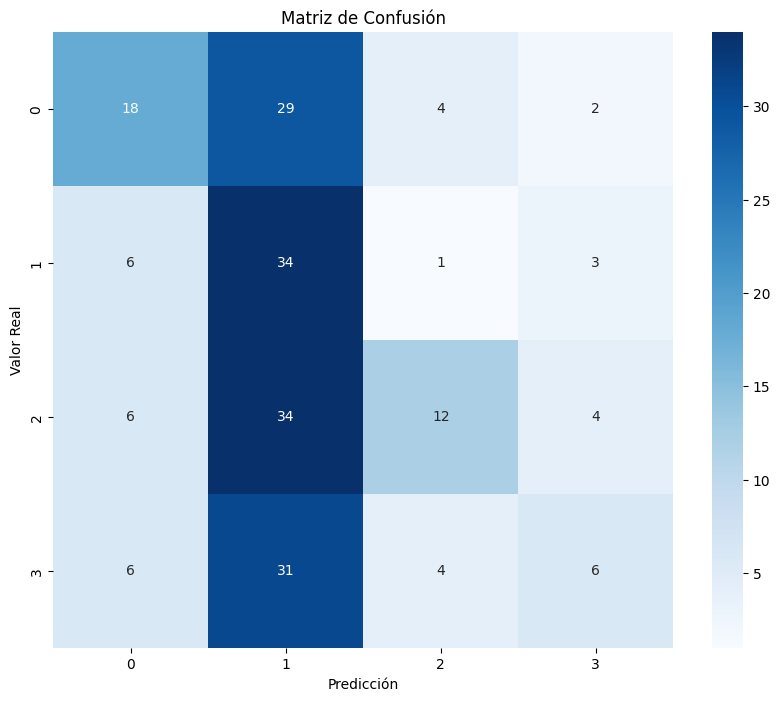

In [36]:
# Evaluación
y_pred = rf_model.predict(X_test)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

In [37]:
# Importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nCaracterísticas más importantes:")
print(feature_importance.head(10))


Características más importantes:
              feature  importance
11  income_per_tenure    0.154776
16   income_education    0.130244
6                  ed    0.125721
12     income_per_age    0.101676
15     tenure_squared    0.082768
5              income    0.055520
1              tenure    0.054130
14     income_squared    0.048267
17         age_income    0.043264
7              employ    0.038341


In [38]:
# Análisis específico de la clase 2
class_2_predictions = (y_pred == 2)
class_2_actual = (y_test == 2)
class_2_correct = np.logical_and(class_2_predictions, class_2_actual)

print("\nAnálisis de errores para la clase 2:")
misclassified_indices = np.where(np.logical_and(class_2_actual, ~class_2_correct))[0]
print(f"Número de casos mal clasificados de clase 2: {len(misclassified_indices)}")


Análisis de errores para la clase 2:
Número de casos mal clasificados de clase 2: 10


In [ ]:
# Guardar el modelo
#import joblib
#joblib.dump(rf_model, 'rf_model_optimized.pkl')